# Parallel Implementation of SPHINCS+With GPUs

> the pdf file is available [here](../related_work/Parallel_Implementation_of_SPHINCS_With_GPUs.pdf)


## Abstract

Therefore, we present highly parallel and optimized implementations of SPHINCS+ on various NVIDIA GPU architectures (Pascal, Turing, and Ampere). We discovered parts within the internal processes of SPHINCS+ that could be parallelized and optimized them (e.g., leaf node generation and node merging process in MSS, subtree constructions in FORS, signature generation in WOTS+ and hypertree layer construction), leveraging the characteristics of GPU architecture (e.g., warp-based execution and efficient memory access).


## Introduction

The Introduction of the Parallel Implementation of SPHINCS+ With GPUs outlines the motivation and context behind the research. Key points include:

- An overview of SPHINCS+ as a post-quantum secure signature scheme and the challenges associated with its computational overhead.
- A discussion on the potential of modern NVIDIA GPU architectures (including Pascal, Turing, and Ampere) to accelerate the cryptographic operations inherent in SPHINCS+.
- Identification of specific internal processes, such as leaf node generation, node merging in the Merkle Signature Scheme (MSS), subtree construction in FORS, WOTS+ signature generation, and hypertree layer construction, where parallelism can be exploited.
- Emphasis on leveraging GPU characteristics like warp-based execution and efficient memory access to significantly improve performance.
- A brief outline of how the subsequent sections of the paper detail the methodology and performance results of the proposed parallel implementations.


## Background

1. Importance of SPHINCS+

Post-Quantum Security: SPHINCS+ is a hash-based digital signature algorithm selected by NIST for standardization, designed to resist attacks from quantum computers. Unlike lattice-based alternatives (e.g., Dilithium), it relies on hash functions, offering security guarantees rooted in classical cryptography.
Performance Challenges: SPHINCS+ is slower than other NIST-selected algorithms (e.g., ~150× slower than Dilithium for signing on CPUs). Optimizing it is critical for real-world applications like TLS, DNSSEC, and high-throughput payment systems.

2. Structure of SPHINCS+
   SPHINCS+ combines three core components:

WOTS+: A one-time signature scheme that splits messages into blocks for signing.
FORS: A few-time signature scheme that divides messages into subtrees for efficiency.
Hypertree: A layered Merkle tree structure that reduces the overhead of leaf node generation.
Each layer in the hypertree involves MSS (Merkle Signature Scheme) operations (leaf generation and node merging) and WOTS+ signing.


3. Key Bottlenecks

Leaf Node Generation: Dominates computation time (e.g., 89% at security level 1).
Hypertree Operations: Multi-layered structure introduces sequential dependencies, limiting parallelism.

4. GPU Architecture & CUDA

Parallelization Potential: GPUs excel at data-parallel tasks due to thousands of cores. CUDA enables programming GPUs for general-purpose computing (GPGPU).
Memory Optimization: Efficient use of shared memory (fast but limited) and avoidance of bank conflicts are critical for performance.

5. Prior Work

SPHINCS on GPUs: Sun et al. (2020) achieved 5,152 signatures/sec on GTX 1080 but did not parallelize hypertree layers.
FPGA Implementations: Focused on accelerating hash functions (e.g., SHA-3) but lacked structural optimizations for SPHINCS+.


## Profiling Results for SPHINCS+

- **Profiling Approach**:  
  SPHINCS+ operations were profiled using the reference C code submitted to the NIST PQC competition, focusing on the signing process.

- **Hardware & Experiment Setup**:  
  The profiling was performed on an AMD Ryzen 9 5900X CPU using a single core. The SPHINCS+SHA256f-simple mode was used.

- **Key Findings**:

  - **Bottleneck Identification**:  
    The hypertree operation, which manages WOTS+-based MSS operations (primarily leaf node generation), was identified as the major computational bottleneck.
  - **Performance Breakdown**:

    - For security level 1, the WOTS+ leaf node generation process accounts for approximately 89% of the overall execution time.
    - At higher security levels (3 and 5), FORS digital signature processing takes about 20% of execution time.

  - **Optimization Focus**:  
    Given that leaf node generation is the dominant workload (especially in WOTS+ and in the FORS-subtree for FORS signatures), the parallelization of the MSS leaf node generation process is recommended as the primary optimization target.


## Parallel Implementation of SPHINCS+

- **Objective**:  
  Improve throughput of SPHINCS+ signing by parallelizing the signature generation process using GPU acceleration.

- **Key Concepts**:

  - **Parallelization Focus**:  
    The signing process is optimized by parallelizing critical operations including FORS digital signature, hypertree MSS (Merkle Signature Scheme) construction, and hypertree WOTS+ (Winternitz One-Time Signature) signing.

  - **GPU Configuration**:
    - Utilizes CUDA, where each CUDA block processes one message.
    - The grid and block configurations are optimized based on the security level.
    - **FORS**: Uses $2^h$ threads per subtree; thread counts vary with the height of the FORS tree (e.g., 6, 8, and 9 for security levels 1, 3, and 5 respectively).
    - **Hypertree MSS**: Consists of $d$ layers, with each layer involving WOTS+ signing and MSS construction. MSS construction uses $(l \times d - 1)$ threads per block.
    - **WOTS+ Signing in Hypertree**:  
      The message is divided into $e$ parts (including checksum), where $d \times e$ threads are required. For security levels 3 and 5, if the required number of threads exceeds 1,024, each thread processes two parts.

- **Implementation Strategy**:  
  The design assigns each DSA (Digital Signature Algorithm operation) a unique thread configuration, ensuring independent and cooperative processing across CUDA blocks for enhanced throughput. The configuration details are summarized in Table III of the original work.


#### Summary of "B. Proposed Hypertree Parallel Methods"

- **Objective:**  
  Introduce a method to parallelize the hypertree computation in SPHINCS+ signing by processing all layers simultaneously.

- **Key Analysis:**

  - **MSS Leaf Node Independence:**  
    The MSS leaf node index (idx_leaf) is derived from the output of the hash_message() function. Since hash_message() is executed before the hypertree layer processes—and because tree is independent of these layers—the leaf node selection in each layer can be predetermined.
  - **WOTS+ Signature Structure:**  
    Although WOTS+ signature generation depends on the MSS root node (except in the 0-th layer using a FORS signature), its independent processing of checksum and message blocks makes it amenable to parallelization.
  - **Breaking Down the Parallel Work:**  
    The MSS process divides the computation into multiple leaf node generations and root node merging steps across the layers.

- **Proposed Parallelization Method:**

  1. **Reordering Computations:**  
     Carry out MSS computations for all layers first, then use the pre-computed MSS root nodes for parallel WOTS+ signature generation.

  2. **Parallel Execution Across Layers:**

     - **MSS Parallel Methods:**  
       Utilize a single CUDA block per hypertree where:

       - For security levels 1 and 3: A CUDA block with 23×21 threads processes 21 layers with 23 MSS leaf nodes per layer.
       - For security level 5: A CUDA block with 24×16 threads processes 16 layers with 24 MSS leaf nodes per layer.
       - Threads are coordinated to generate leaf nodes in parallel followed by a merging phase for computing MSS root nodes.

     - **WOTS+ Signature Parallel Methods:**  
       Assign each CUDA thread to handle one WOTS+ message block. For instance, at security level 1, 35 threads (organized as one slot) generate the signature for a layer, and a CUDA block handles all 22 layers. For higher security levels with more signature parts, each thread is tasked with processing two signature blocks to manage CUDA thread limitations.


#### Summary of "FORS signature and Proposed MSS Parallel Method"

- **FORS signature Using t Threads:**

  - **Independent Subtrees:** Since each subtree is built independently, they can be processed in parallel.
  - **Shared Memory Utilization:** Full advantage is taken of the shared memory to accelerate subtree construction.
  - **Thread Limitation:** To avoid exceeding shared memory capacity, only t threads (26 for security level 1, 28 for level 3, and 29 for level 5) are used per subtree.
  - **Iterative Process:** t threads collaboratively construct a subtree by generating leaf nodes and merging them; this process is iterated k times.

- **Proposed MSS Parallel Method:**
  - **MSS Operations Breakdown:** MSS consists of generating leaf nodes (via FORS or WOTS+ key generation) and computing the root node by merging nodes.
  - **CUDA Parallelization:**
    - Threads are allocated corresponding to the number of leaves in both the FORS subtree (t) and the hypertree.
    - Each thread generates a single leaf node.
    - In the merging phase, half the threads combine two child nodes (using \_\_syncthreads() for synchronization) with the process iterated until the root is computed.
- **Efficient Shared Memory Usage in MSS Merging:**
  - **Merging Process:** Parent nodes are computed by concatenating and hashing child nodes.
  - **Minimizing Bank Conflicts:**
    - Computed node values are stored in alternating even and odd positions in shared memory.
    - This storage strategy minimizes bank conflicts and keeps memory accesses within the warp’s 128-byte access unit, optimizing the merging process.


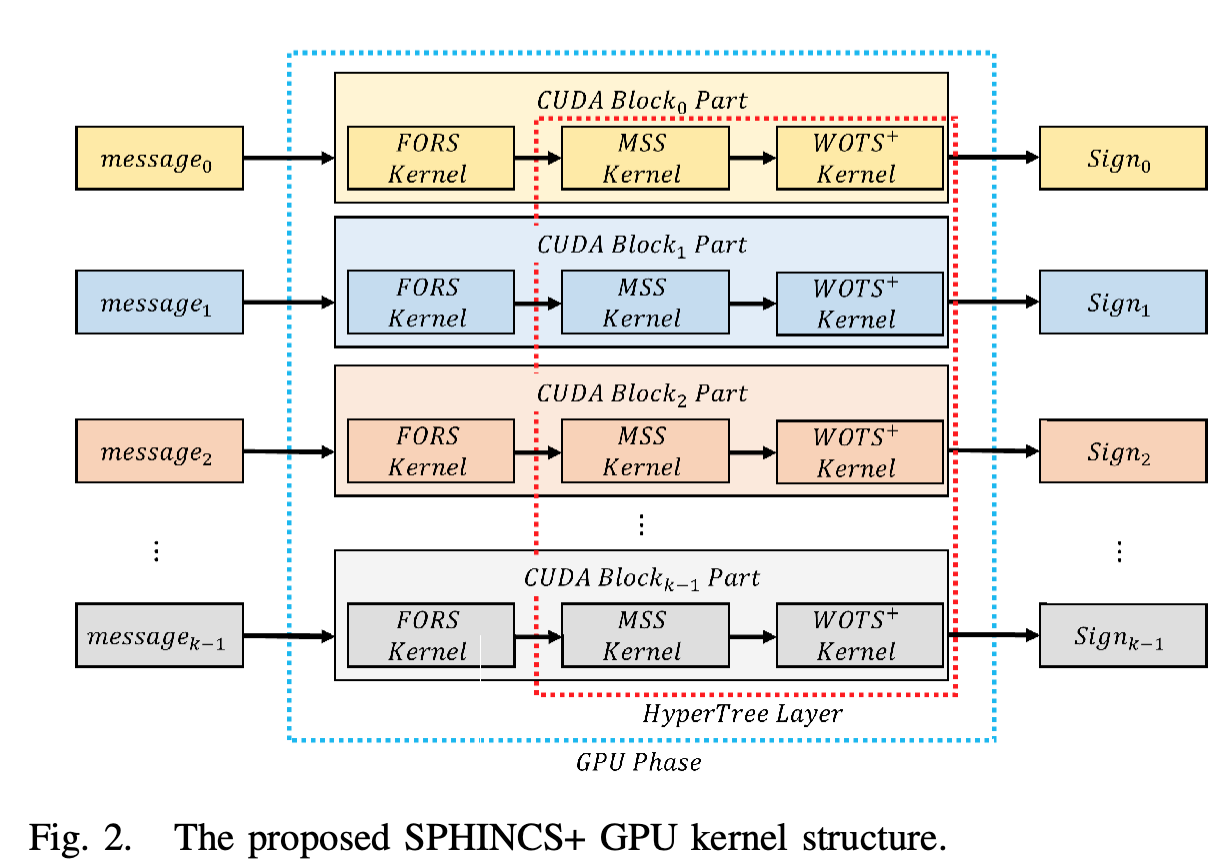


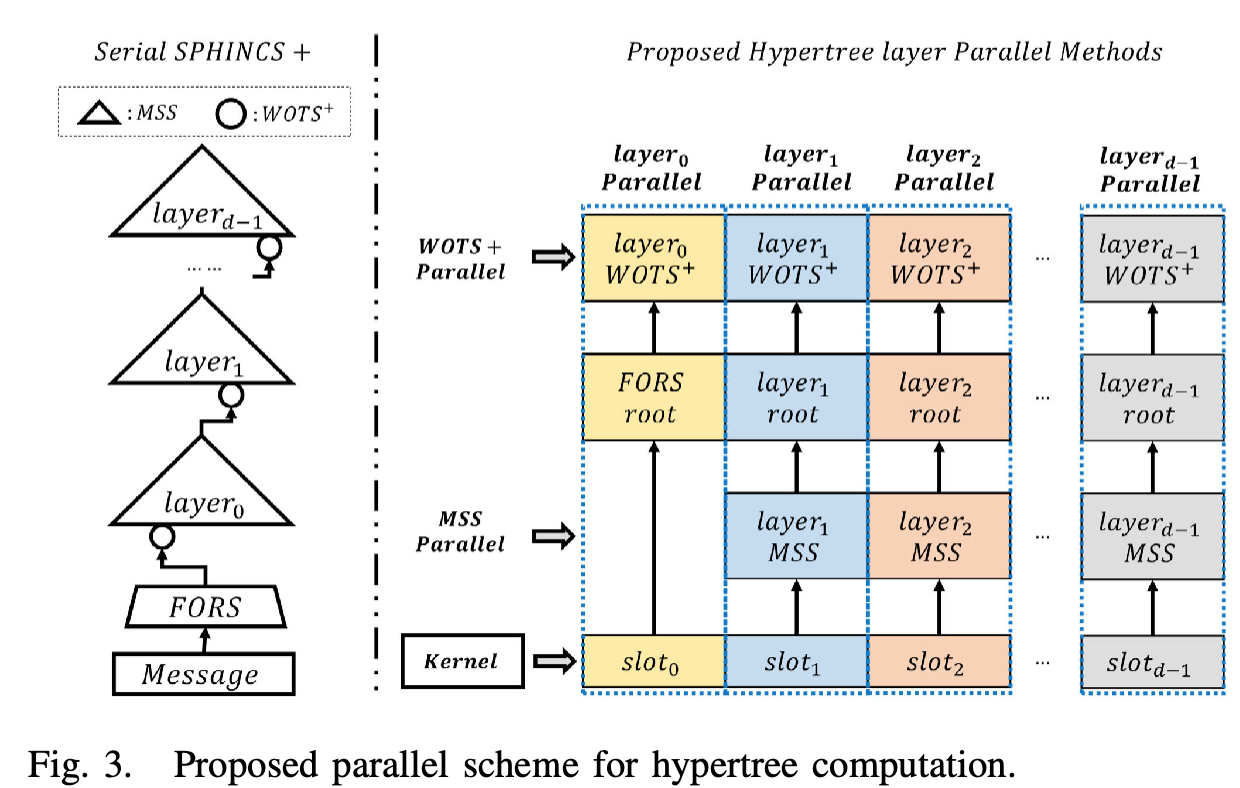


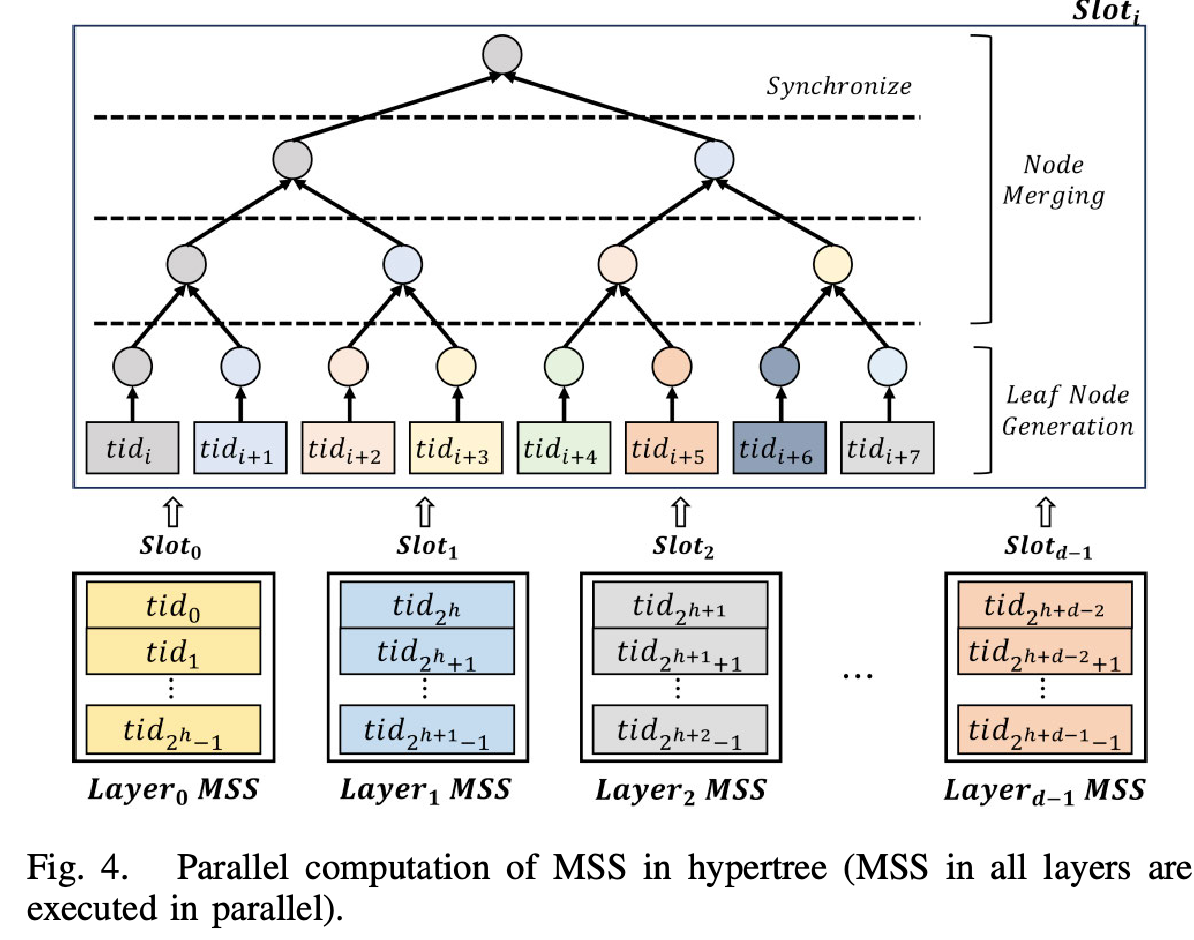


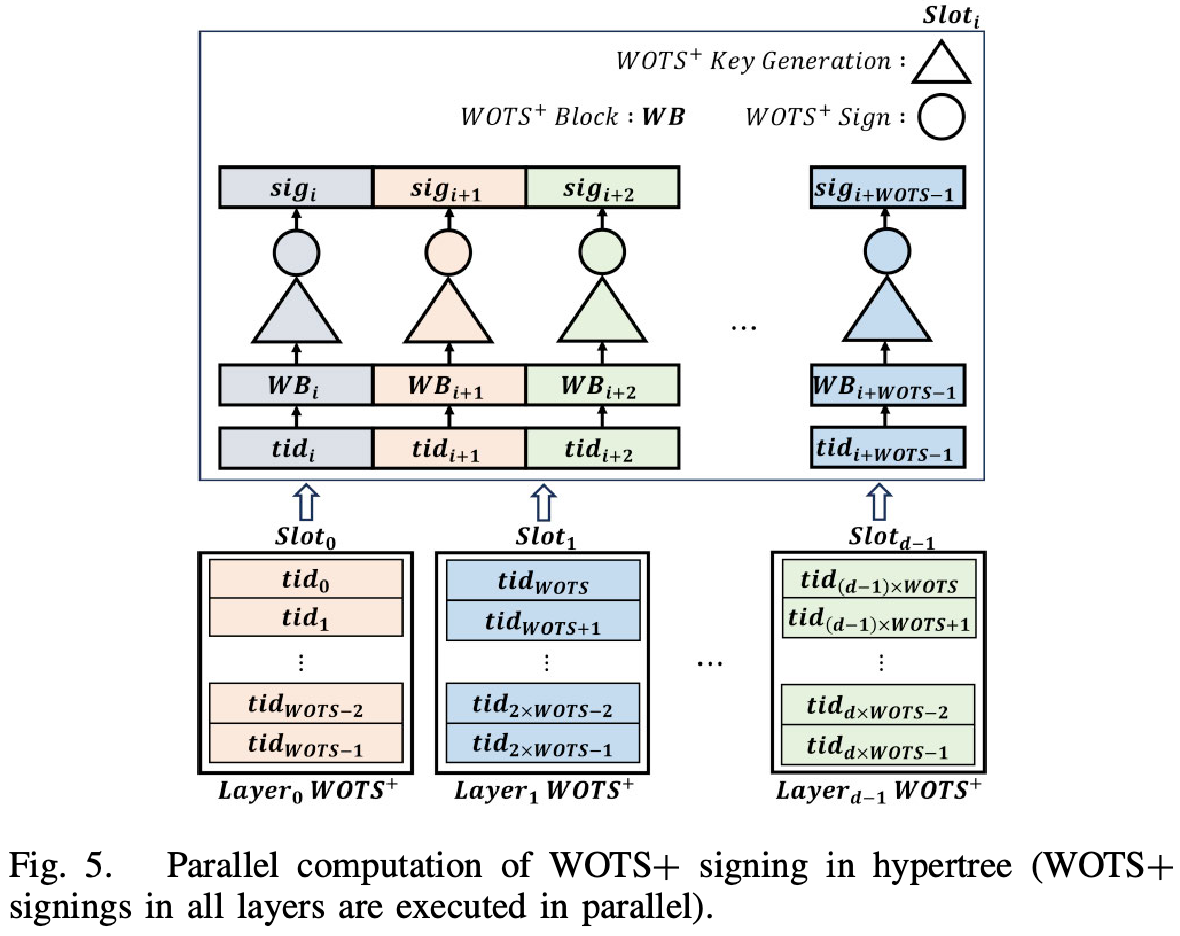


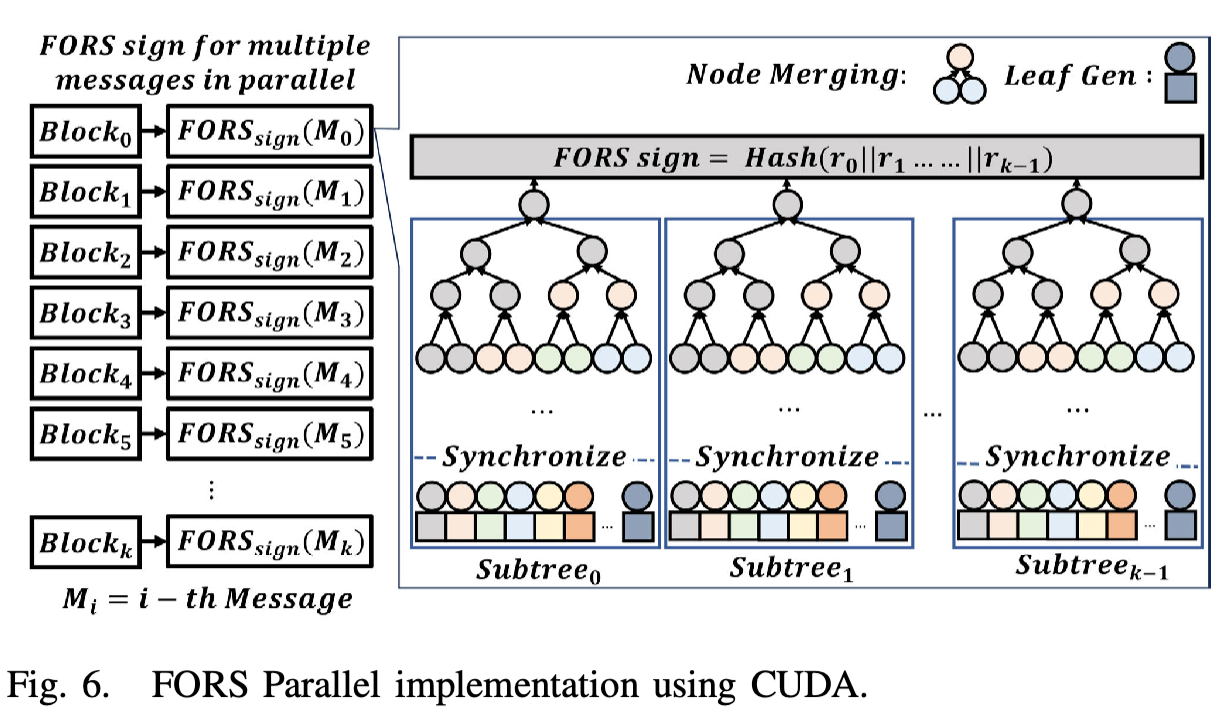
